Treure variables que no tenen correlació i fan soroll

In [59]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#### Tornem a carregar el primer nivell

In [60]:
odor = pd.read_json('Data/odor_prop.json', lines=False, orient='records')
odor=odor[odor['level']=='first']
odor.reset_index(drop=True, inplace=True)
mol=odor['cid'].value_counts()
mols=mol.index[mol>1]
groups=[]
for i in range(len(odor)):
    for mol in mols:
        if odor['cid'][i] == mol:
            g=np.max(odor[odor['cid']==mol]['label'])
            groups.append([mol, g])
            ls_drop=[]
for mol in groups:
    for i in range(len(odor)):
        if (odor['cid'][i] == mol[0]):
            if odor['label'][i]!=mol[1]:
                ls_drop.append(i)
odor=odor.drop(ls_drop)
odor.reset_index(drop=True, inplace=True)
odor = odor.sort_values(by='cid')
odor.reset_index(inplace=True)
ls_repeat=[]
for i in range(len(odor)-1):
    if (odor['cid'][i]==odor['cid'][i+1]):
        ls_repeat.append(i)
odor=odor.drop(ls_repeat)

In [61]:
odor.iloc[:,4:59]

,label,smiles,TPSA,MolLogP,MolWt,ExactMolWt,MolMR,NumHAcceptors,NumHDonors,NumRotatableBonds,...,Eccentricity,InertialShapeFactor,RadiusOfGyration,Asphericity,SpherocityIndex,PMI1,PMI2,PMI3,NPR1,NPR2
0,4,CC(C)C(=O)C(=O)O,54.37,0.29610,116.116,116.047344,27.4808,2,1,2,...,0.938067,0.004971,1.964716,0.298449,0.246056,148.857521,317.924313,429.659337,0.346455,0.739945
1,5,CCC(=O)C(=O)O,54.37,0.05010,102.089,102.031694,22.9338,2,1,2,...,0.967492,0.008151,1.916097,0.429994,0.148872,93.924062,284.315371,371.385266,0.252902,0.765554
2,4,CC(C)CC(=O)C(=O)O,54.37,0.68620,130.143,130.062994,32.0978,2,1,3,...,0.958517,0.004836,2.209024,0.374273,0.329791,171.302808,497.850680,600.987076,0.285036,0.828388
3,6,C1=CC(=C(C=C1C(=O)O)O)O,77.76,0.79600,154.121,154.026609,36.7309,3,3,1,...,0.976036,0.003839,2.465587,0.489205,0.001511,203.865902,733.138397,936.836062,0.217611,0.782569
4,4,C1=CC=C(C=C1)CCC(=O)O,37.30,1.70380,150.177,150.068080,42.3988,1,1,3,...,0.947581,0.003729,2.386364,0.330179,0.367010,244.806354,699.448694,766.181173,0.319515,0.912902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,5,CCOC(=O)C1=C(OC(=C1O)C)C,59.67,1.77874,184.191,184.073559,45.8033,4,1,2,...,0.959416,0.002106,2.646805,0.385572,0.113703,357.604196,954.993714,1268.129836,0.281993,0.753073
3445,4,CCCCCCCCCC(=O)CC(=O)O.CC(CO)[O-],97.66,1.89840,289.392,289.202048,76.4176,4,2,11,...,0.989505,0.002235,3.359304,0.634963,0.244771,442.417189,3027.322660,3061.794054,0.144496,0.988741
3446,4,CC(=O)CC[C@H]1C(=C)CCCC1(C)C,17.07,3.73810,194.318,194.167065,60.1770,1,0,3,...,0.953960,0.002133,2.765244,0.353602,0.348291,409.942742,1195.021208,1366.771194,0.299935,0.874339
3447,4,C[C@@H]1CC[C@H]([C@]12CCC(=CC2)C)C(C)(C)O,20.23,3.92000,222.372,222.198365,68.2268,1,1,1,...,0.905091,0.001409,2.670891,0.205799,0.497367,595.679021,1176.093774,1400.878383,0.425218,0.839540


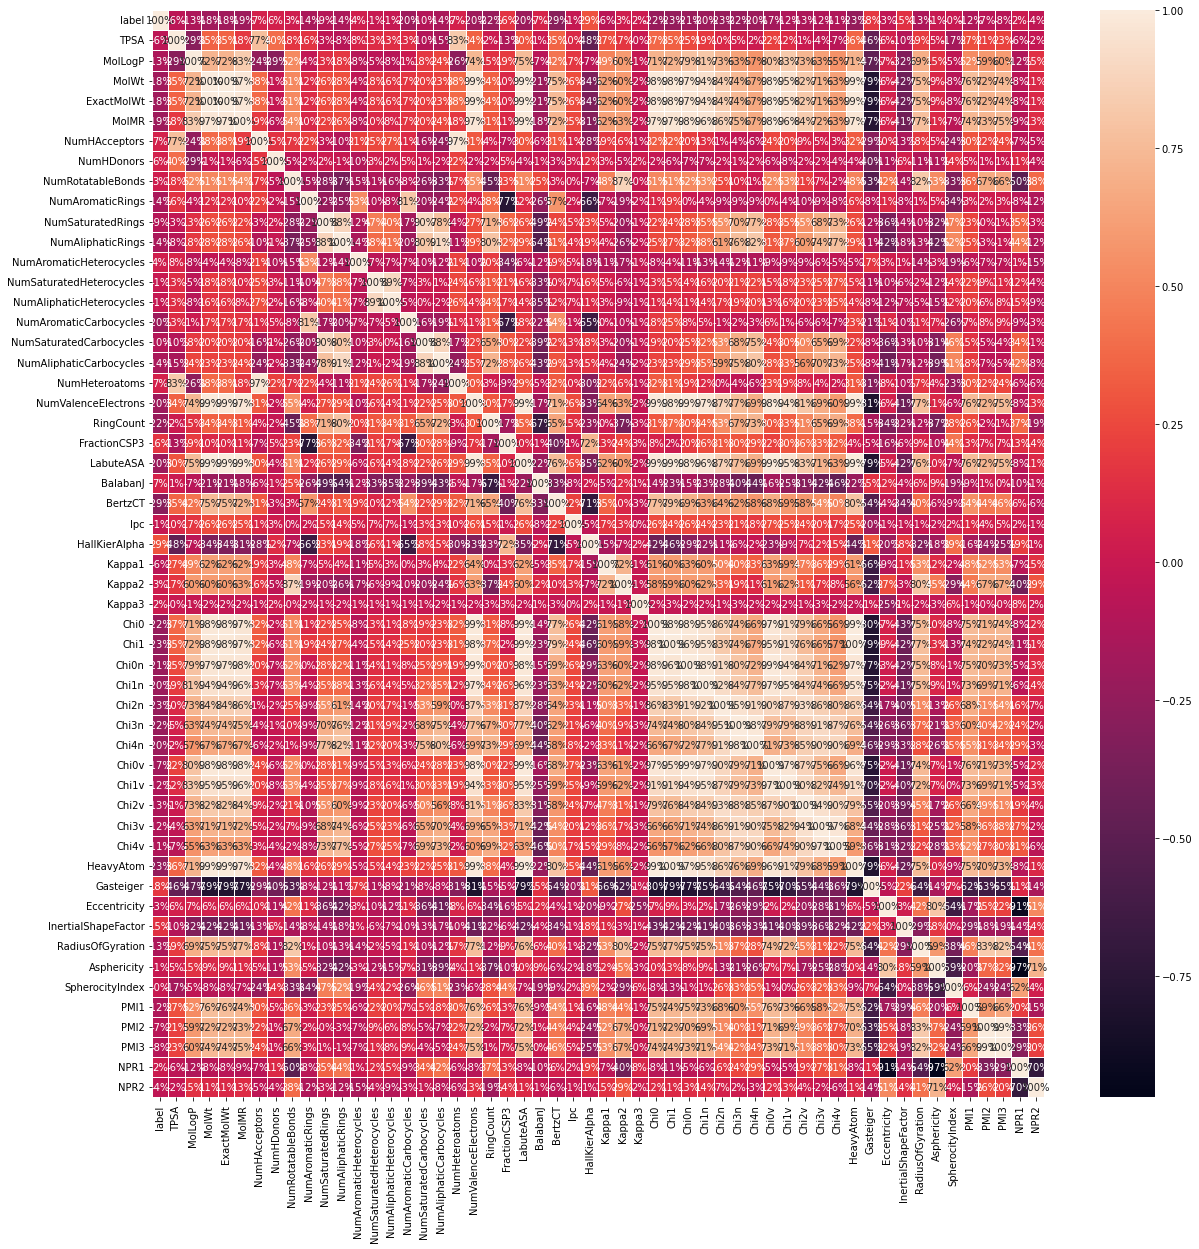

In [62]:
# Mirem la correlació entre els atributs d'entrada
correlacio = odor.iloc[:,4:59].corr()
plt.figure(figsize=(20,20))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5, fmt='.0%')

In [63]:
#Borrar les correlacions més petites a 0.1:

In [64]:
abs(correlacio['label'])

label                       1.000000
TPSA                        0.056257
MolLogP                     0.126537
MolWt                       0.178202
ExactMolWt                  0.178358
MolMR                       0.193853
NumHAcceptors               0.067249
NumHDonors                  0.058581
NumRotatableBonds           0.032557
NumAromaticRings            0.143994
NumSaturatedRings           0.088177
NumAliphaticRings           0.137670
NumAromaticHeterocycles     0.038428
NumSaturatedHeterocycles    0.006203
NumAliphaticHeterocycles    0.014131
NumAromaticCarbocycles      0.196106
NumSaturatedCarbocycles     0.096500
NumAliphaticCarbocycles     0.144256
NumHeteroatoms              0.066774
NumValenceElectrons         0.198973
RingCount                   0.220815
FractionCSP3                0.164962
LabuteASA                   0.203669
BalabanJ                    0.073741
BertzCT                     0.288845
Ipc                         0.010837
HallKierAlpha               0.290847
K

In [65]:
columns_drop = abs(correlacio['label'])[abs(correlacio['label'])<0.1].index

In [69]:
odor=odor.drop(['TPSA', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds',
       'NumSaturatedRings', 'NumAromaticHeterocycles',
       'NumSaturatedHeterocycles', 'NumAliphaticHeterocycles',
       'NumSaturatedCarbocycles', 'NumHeteroatoms', 'BalabanJ', 'Ipc',
       'Kappa1', 'Kappa2', 'Kappa3', 'Eccentricity', 'Asphericity',
       'SpherocityIndex', 'PMI2', 'PMI3', 'NPR1', 'NPR2'], axis=1)

In [73]:
ind_X=odor.columns[6:37]
X = odor[ind_X]
y = odor['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

In [74]:
odor

,index,name,level,cid,label,smiles,MolLogP,MolWt,ExactMolWt,MolMR,...,Class,Subclass,Intermediate Nodes,Direct Parent,Alternative Parents,Molecular Framework,Substituents,Structure-based description,Ancestors,External Descriptors
0,2210,fruity,first,49,4,CC(C)C(=O)C(=O)O,0.29610,116.116,116.047344,27.4808,...,None,None,None,None,None,None,None,None,None,None
1,3245,caramellic,first,58,5,CCC(=O)C(=O)O,0.05010,102.089,102.031694,22.9338,...,None,None,None,None,None,None,None,None,None,None
2,2054,fruity,first,70,4,CC(C)CC(=O)C(=O)O,0.68620,130.143,130.062994,32.0978,...,None,None,None,None,None,None,None,None,None,None
3,1034,phenolic,first,72,6,C1=CC(=C(C=C1C(=O)O)O)O,0.79600,154.121,154.026609,36.7309,...,None,None,None,None,None,None,None,None,None,None
4,2696,fatty,first,107,4,C1=CC=C(C=C1)CCC(=O)O,1.70380,150.177,150.068080,42.3988,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,3232,caramellic,first,90479169,5,CCOC(=O)C1=C(OC(=C1O)C)C,1.77874,184.191,184.073559,45.8033,...,None,None,None,None,None,None,None,None,None,None
3445,2784,fatty,first,92043681,4,CCCCCCCCCC(=O)CC(=O)O.CC(CO)[O-],1.89840,289.392,289.202048,76.4176,...,None,None,None,None,None,None,None,None,None,None
3446,2783,fatty,first,92256353,4,CC(=O)CC[C@H]1C(=C)CCCC1(C)C,3.73810,194.318,194.167065,60.1770,...,None,None,None,None,None,None,None,None,None,None
3447,1863,fruity,first,101306697,4,C[C@@H]1CC[C@H]([C@]12CCC(=CC2)C)C(C)(C)O,3.92000,222.372,222.198365,68.2268,...,None,None,None,None,None,None,None,None,None,None


In [75]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LinearDiscriminantAnalysis(),
    make_pipeline(StandardScaler(), SVC(gamma='auto')),
    svm.SVC()
    ]

# Logging for Visual Comparison


for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
      
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 33.0652%
DecisionTreeClassifier
****Results****
Accuracy: 36.2824%
RandomForestClassifier
****Results****
Accuracy: 44.5040%
LinearDiscriminantAnalysis
****Results****
Accuracy: 46.5594%
Pipeline
****Results****
Accuracy: 44.4147%
SVC
****Results****
Accuracy: 32.7971%
